### Import Library

In [296]:
import pandas as pd
from urllib.parse import unquote
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
import re
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import seaborn as sns
import pickle
import xgboost

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [297]:
# Configure
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

### Import Data

In [305]:
# Attack Data Sql
df_at = pd.read_csv('attack_sql2.txt', delimiter = "\t", header=None)
df_at.columns = ['Log']
df_at['Label'] =  1

df_no = pd.read_csv('safe_sql.txt', delimiter = "\t", header=None)
df_no.columns = ['Log']
df_no['Label'] = 0

In [306]:
df = df_at.append(df_no, ignore_index=True, sort=False)

In [307]:
df_at.head()

,Log,Label
0,"36.72.215.113 - - [23/Apr/2021:02:30:47 +0000] ""GET /mod.php?kategori=lounge&id=4%20order%20by%2...",1
1,"36.72.215.113 - - [23/Apr/2021:02:30:52 +0000] ""GET /mod.php?kategori=lounge&id=4%20order%20by%2...",1
2,"36.72.215.113 - - [23/Apr/2021:02:30:58 +0000] ""GET /mod.php?kategori=lounge&id=4%20order%20by%2...",1
3,"36.72.215.113 - - [23/Apr/2021:02:31:06 +0000] ""GET /mod.php?kategori=lounge&id=4%20order%20by%2...",1
4,"36.72.215.113 - - [23/Apr/2021:02:31:09 +0000] ""GET /mod.php?kategori=lounge&id=4%20order%20by%2...",1


In [308]:
df.head()

,Log,Label
0,"36.72.215.113 - - [23/Apr/2021:02:30:47 +0000] ""GET /mod.php?kategori=lounge&id=4%20order%20by%2...",1
1,"36.72.215.113 - - [23/Apr/2021:02:30:52 +0000] ""GET /mod.php?kategori=lounge&id=4%20order%20by%2...",1
2,"36.72.215.113 - - [23/Apr/2021:02:30:58 +0000] ""GET /mod.php?kategori=lounge&id=4%20order%20by%2...",1
3,"36.72.215.113 - - [23/Apr/2021:02:31:06 +0000] ""GET /mod.php?kategori=lounge&id=4%20order%20by%2...",1
4,"36.72.215.113 - - [23/Apr/2021:02:31:09 +0000] ""GET /mod.php?kategori=lounge&id=4%20order%20by%2...",1


<AxesSubplot:title={'center':'Count (target)'}>

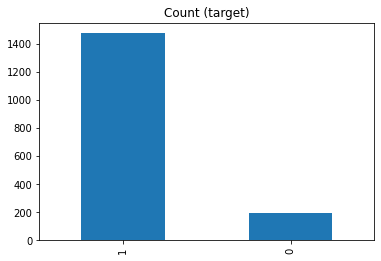

In [309]:
df.Label.value_counts().plot(kind='bar', title='Count (target)')

In [310]:
df_at.shape

(1476, 2)

### Preprocessing

In [311]:
def preprocessing(df):
    df['Ip'] = df['Log'].str.split(' - - ').str[0]

    df['Time'] = df['Log'].str.split('] ').str[0]
    df['Time'] = df['Time'].str.split(' - - ').str[1]+']'

    df['Log2'] = df['Log'].str.split('] ').str[1]


    df['Request'] = df['Log2'].str.split('"').str[1]
    df['Request'] = df['Request'].apply(lambda x : re.sub(r'^.*?php?', '', x))

    df['Angka'] = df['Log2'].str.split('"').str[2]

    df['Kembalian'] = df['Log2'].str.split('"').str[3]

    df['User_Header'] = df['Log2'].str.split('"').str[-2]

    df.drop(['Log','Log2','Angka','Kembalian','User_Header'], axis=1, inplace=True)
    
    return df

def preprocess(a):
    a = a.lower().replace('(',' ').replace(')',' ').strip()
    a = ' '.join(a.split())
    a = a.split()
    return a

def count_string2(data, list_words):
    total = 0
    for word in list_words:
        counter = data.count(word)
        total += counter
    return total

def check_always_true(data):
    return bool(re.findall(r"\d=\d",data))

def feature_engineering(df):
    df['Request1'] = df['Request'].str.replace('GET /', '')
    df['Request1'] = df['Request1'].str.replace('POST /', '')
    df['Request1'] = df['Request1'].str.replace('HTTP/1.1', '')
    df['Request1'] = df['Request1'].str.lower()
    df['Request2'] = df['Request1'].apply(lambda x : unquote(x))

    df['Comment_Count'] = df['Request2'].apply(lambda x : count_string2(x, ['--','/**/']))
    df['Operator_Count'] = df['Request2'].apply(lambda x : count_string2(x, ['<','>','<=','>=', '==', '!=','&&', '||' '<<', '>>', '|', '+', '%', '^']))
    df['SqlKeyword_Count'] = df['Request2'].apply(lambda x : count_string2(x, ['select', 'update', 'insert', 'create', 'drop', 'alter', 'rename', 'group', 'union', 'having', 
                                                                            'concat', 'order','values', 'declare', 'substring', 'table']))
    df.loc[df['SqlKeyword_Count']>=1, 'Any_SQL_Keyword'] = 1
    df.loc[df['SqlKeyword_Count']<1, 'Any_SQL_Keyword'] = 0
    df['Any_SQL_Keyword'] = df['Any_SQL_Keyword'].astype(bool)

    df['Semicolon_Count'] = df['Request2'].apply(lambda x : count_string2(x, ';'))

    df['Any_Always_True'] = df['Request2'].apply(lambda x: check_always_true(x))

    df = df[[ 'Label', 'Ip', 'Time','Request2',
           'Comment_Count', 'Operator_Count',
           'SqlKeyword_Count', 'Any_Always_True','Any_SQL_Keyword','Semicolon_Count']]
    
    return df

def clean_text(text):
    text_rc = re.sub('[0-9]+', '', text)
    tokens = re.split('\W+', text_rc)    # tokenization
    return tokens

def term_frequency(df):
    vectorizer = CountVectorizer(analyzer=clean_text, decode_error="replace",vocabulary=pickle.load(open("vocab.pkl", "rb")))
    tfidf = vectorizer.fit_transform(df['Request2'])

    vect_df = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names())
    vect_df = vect_df[['select', 'union', 'concat', 'null', 'like', 'or','exec','and','having','char', 'order']]
    df_tf = pd.concat([df.reset_index(drop=True), vect_df.reset_index(drop=True)], axis=1)
    pickle.dump(vectorizer.vocabulary_,open("vocab.pkl","wb"))

    return df_tf

def pipeline(df):
    test_bersih = preprocessing(df)
    test_fe = feature_engineering(test_bersih)
    test_tf = term_frequency(test_fe)
    
    return test_tf

#### Split Data

In [312]:
df_split = preprocessing(df)

In [313]:
df_split.head()

,Label,Ip,Time,Request
0,1,36.72.215.113,[23/Apr/2021:02:30:47 +0000],?kategori=lounge&id=4%20order%20by%2010--%20- HTTP/1.1
1,1,36.72.215.113,[23/Apr/2021:02:30:52 +0000],?kategori=lounge&id=4%20order%20by%20106--%20- HTTP/1.1
2,1,36.72.215.113,[23/Apr/2021:02:30:58 +0000],?kategori=lounge&id=4%20order%20by%20101--%20- HTTP/1.1
3,1,36.72.215.113,[23/Apr/2021:02:31:06 +0000],?kategori=lounge&id=4%20order%20by%201--%20- HTTP/1.1
4,1,36.72.215.113,[23/Apr/2021:02:31:09 +0000],?kategori=lounge&id=4%20order%20by%202--%20- HTTP/1.1


#### Feature Engineering

In [314]:
df_fe = feature_engineering(df_split)

In [315]:
df_fe.tail()

,Label,Ip,Time,Request2,Comment_Count,Operator_Count,SqlKeyword_Count,Any_Always_True,Any_SQL_Keyword,Semicolon_Count
1666,0,36.72.215.113,[23/Apr/2021:02:29:59 +0000],images/header-bg.png,0,0,0,False,False,0
1667,0,36.72.215.113,[23/Apr/2021:02:29:59 +0000],images/loginform-bg.png,0,0,0,False,False,0
1668,0,36.72.215.113,[23/Apr/2021:02:29:59 +0000],images/list_icon.png,0,0,0,False,False,0
1669,0,36.72.215.113,[23/Apr/2021:02:30:01 +0000],?kategori=lounge&id=4,0,0,0,False,False,0
1670,0,36.72.215.113,[23/Apr/2021:02:30:18 +0000],?kategori=lounge&id=4',0,0,0,False,False,0


#### Term Frequency & TF-Idf

In [316]:
df_tf = term_frequency(df_fe)

In [382]:
df_tf

,Label,Ip,Time,Request2,Comment_Count,Operator_Count,SqlKeyword_Count,Any_Always_True,Any_SQL_Keyword,Semicolon_Count,select,union,concat,null,like,or,exec,and,having,char,order
0,1,36.72.215.113,[23/Apr/2021:02:30:47 +0000],?kategori=lounge&id=4 order by 10-- -,1,0,1,False,True,0,0,0,0,0,0,0,0,0,0,0,1
1,1,36.72.215.113,[23/Apr/2021:02:30:52 +0000],?kategori=lounge&id=4 order by 106-- -,1,0,1,False,True,0,0,0,0,0,0,0,0,0,0,0,1
2,1,36.72.215.113,[23/Apr/2021:02:30:58 +0000],?kategori=lounge&id=4 order by 101-- -,1,0,1,False,True,0,0,0,0,0,0,0,0,0,0,0,1
3,1,36.72.215.113,[23/Apr/2021:02:31:06 +0000],?kategori=lounge&id=4 order by 1-- -,1,0,1,False,True,0,0,0,0,0,0,0,0,0,0,0,1
4,1,36.72.215.113,[23/Apr/2021:02:31:09 +0000],?kategori=lounge&id=4 order by 2-- -,1,0,1,False,True,0,0,0,0,0,0,0,0,0,0,0,1
5,1,36.72.215.113,[23/Apr/2021:02:31:13 +0000],?kategori=lounge&id=4 order by 3-- -,1,0,1,False,True,0,0,0,0,0,0,0,0,0,0,0,1
6,1,36.72.215.113,[23/Apr/2021:02:31:16 +0000],?kategori=lounge&id=4 order by 4-- -,1,0,1,False,True,0,0,0,0,0,0,0,0,0,0,0,1
7,1,36.72.215.113,[23/Apr/2021:02:31:58 +0000],?kategori=lounge&id=4 order by 5-- -,1,0,1,False,True,0,0,0,0,0,0,0,0,0,0,0,1
8,1,36.72.215.113,[23/Apr/2021:02:32:00 +0000],?kategori=lounge&id=4 order by 6-- -,1,0,1,False,True,0,0,0,0,0,0,0,0,0,0,0,1
9,1,36.72.215.113,[23/Apr/2021:02:32:02 +0000],?kategori=lounge&id=4 order by 7-- -,1,0,1,False,True,0,0,0,0,0,0,0,0,0,0,0,1


### Oversampling

In [340]:
test = df_tf.copy()
X_tf = test.drop(['Label',], axis=1)
y_tf = test['Label']
X_tf = X_tf.iloc[:,2:]
X_tf = X_tf.drop_duplicates(keep='first')

In [349]:
test = df_tf.copy()
test = test.drop_duplicates(keep='first', subset = ['Request2'])
X_tf = test.drop(['Label',], axis=1)
y_tf = test['Label']
X_tf = X_tf.iloc[:,3:]
print(X_tf.shape)

smote = SMOTE(sampling_strategy='minority')
X_sm_tf, y_sm_tf = smote.fit_sample(X_tf, y_tf)

df_sm_tf = pd.concat([X_sm_tf, y_sm_tf.reindex(X_sm_tf.index)], axis=1)

# Move Label to 1st
first_column = df_sm_tf.pop('Label')
df_sm_tf.insert(0, 'Label', first_column)

(761, 17)


In [350]:
df_sm_tf.tail(10)

,Label,Comment_Count,Operator_Count,SqlKeyword_Count,Any_Always_True,Any_SQL_Keyword,Semicolon_Count,select,union,concat,null,like,or,exec,and,having,char,order
1442,0,0,0,0,False,False,0,0,0,0,0,0,0,0,0,0,0,0
1443,0,0,0,0,False,False,0,0,0,0,0,0,0,0,0,0,0,0
1444,0,0,0,0,False,False,0,0,0,0,0,0,0,0,0,0,0,0
1445,0,0,0,0,False,False,0,0,0,0,0,0,0,0,0,0,0,0
1446,0,0,0,0,False,False,0,0,0,0,0,0,0,0,0,0,0,0
1447,0,0,0,0,False,False,0,0,0,0,0,0,0,0,0,0,0,0
1448,0,0,0,0,False,False,0,0,0,0,0,0,0,0,0,0,0,0
1449,0,0,0,0,False,False,0,0,0,0,0,0,0,0,0,0,0,0
1450,0,0,0,0,False,False,0,0,0,0,0,0,0,0,0,0,0,0
1451,0,0,0,0,False,False,0,0,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:title={'center':'Count (target)'}>

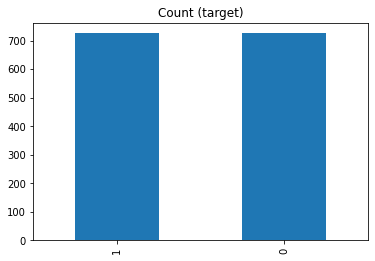

In [351]:
df_sm_tf.Label.value_counts().plot(kind='bar', title='Count (target)')

### Modelling TF

In [352]:
df_sm_tf.corr()

,Label,Comment_Count,Operator_Count,SqlKeyword_Count,Any_Always_True,Any_SQL_Keyword,Semicolon_Count,select,union,concat,null,like,or,exec,and,having,char,order
Label,1.000000,0.724749,0.160668,0.760120,0.326661,0.897758,0.096228,0.697360,0.638197,0.588683,0.417219,0.037139,0.112037,0.037139,0.338595,0.037139,0.087891,0.142757
Comment_Count,0.724749,1.000000,-0.030109,0.731185,-0.158798,0.755218,0.082258,0.414822,0.827889,0.680307,0.529593,0.050629,-0.081199,0.128174,-0.176576,-0.026916,-0.029290,0.194608
Operator_Count,0.160668,-0.030109,1.000000,0.020477,0.405518,0.149416,0.102058,0.209166,-0.097391,-0.105752,-0.075278,-0.006838,-0.016389,0.056404,0.463208,-0.006838,0.275663,-0.026285
SqlKeyword_Count,0.760120,0.731185,0.020477,1.000000,0.177817,0.846686,-0.056699,0.817310,0.860600,0.857289,0.515654,0.034961,0.197252,0.056025,-0.012652,0.056025,0.029773,-0.027546
Any_Always_True,0.326661,-0.158798,0.405518,0.177817,1.000000,0.204275,-0.035372,0.433731,-0.120620,0.011808,-0.134098,-0.012132,0.342977,0.113693,0.610164,0.113693,0.250448,-0.046633
Any_SQL_Keyword,0.897758,0.755218,0.149416,0.846686,0.204275,1.000000,0.057224,0.776779,0.710878,0.655725,0.464734,0.041369,0.124796,0.041369,0.172214,0.041369,0.097900,0.159015
Semicolon_Count,0.096228,0.082258,0.102058,-0.056699,-0.035372,0.057224,1.000000,0.040841,-0.102617,-0.108938,-0.073732,-0.006873,-0.020733,0.192711,-0.046556,-0.006873,-0.016264,-0.026418
select,0.697360,0.414822,0.209166,0.817310,0.433731,0.776779,0.040841,1.000000,0.570222,0.480692,0.272331,0.024242,0.308423,0.024242,0.245283,0.024242,0.168613,-0.099553
union,0.638197,0.827889,-0.097391,0.860600,-0.120620,0.710878,-0.102617,0.570222,1.000000,0.751287,0.565873,0.053985,0.006618,0.053985,-0.191019,-0.023702,-0.056092,-0.091107
concat,0.588683,0.680307,-0.105752,0.857289,0.011808,0.655725,-0.108938,0.480692,0.751287,1.000000,0.569201,0.024548,0.074054,-0.021863,-0.139413,0.024548,-0.051740,-0.084038


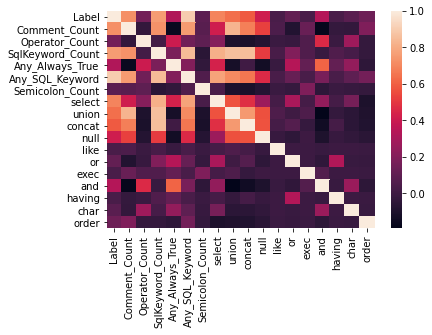

In [353]:
sns.heatmap(df_sm_tf.corr());

### ML Model

In [354]:
classifiers = []

model1 = xgboost.XGBClassifier()
classifiers.append(model1)
model2 = svm.SVC()
classifiers.append(model2)
model3 = tree.DecisionTreeClassifier()
classifiers.append(model3)
model4 = RandomForestClassifier()
classifiers.append(model4)

#### Split Train, Validation, Test Data

In [355]:
X = df_sm_tf.drop(['Label'], axis=1)
y = df_sm_tf['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [356]:
X_train.shape, X_val.shape, X_test.shape

((928, 17), (233, 17), (291, 17))

In [357]:
df_sm_tf.to_csv('data_train_tf.csv')

#### Find best ML Predictor

In [358]:
classifiers = []

model1 = xgboost.XGBClassifier()
classifiers.append(model1)
model2 = svm.SVC()
classifiers.append(model2)
model3 = tree.DecisionTreeClassifier()
classifiers.append(model3)
model4 = RandomForestClassifier()
classifiers.append(model4)

In [359]:
X_val.shape, y_pred1.shape

((233, 17), (236,))

In [360]:
y_val.shape, y_pred1.shape

((233,), (236,))

In [361]:
# Evalueagte using Validation data
for clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred1 = clf.predict(X_val)
    y_pred2 = clf.predict(X_test)
    acc1 = accuracy_score(y_val, y_pred1)
    acc2 = accuracy_score(y_test, y_pred2)
    print("Accuracy using Validation data of %s is %s"%(clf, acc1))
    print("Accuracy using Test data of %s is %s"%(clf, acc2))
    
    cm = confusion_matrix(y_val, y_pred1)
    # print("Confusion Matrix of %s is %s"%(clf, cm))

Accuracy using Validation data of XGBClassifier() is 0.9871244635193133
Accuracy using Test data of XGBClassifier() is 0.9828178694158075
Accuracy using Validation data of SVC() is 0.9871244635193133
Accuracy using Test data of SVC() is 0.979381443298969
Accuracy using Validation data of DecisionTreeClassifier() is 0.9871244635193133
Accuracy using Test data of DecisionTreeClassifier() is 0.9862542955326461
Accuracy using Validation data of RandomForestClassifier() is 0.9871244635193133
Accuracy using Test data of RandomForestClassifier() is 0.9862542955326461


#### Using Decision Tree with Cross Validation

In [362]:
X = df_sm_tf.drop(['Label'], axis=1)
y = df_sm_tf['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [363]:
clf = tree.DecisionTreeClassifier()
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(scores)
mod = clf.fit(X_train, y_train)
y_pred = mod.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy of %s is %s"%(clf, acc))
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))

[0.97854077 0.98706897 0.98706897 0.99137931 0.99137931]
Accuracy of DecisionTreeClassifier() is 0.9862542955326461
              precision    recall  f1-score   support

     class 0       0.97      1.00      0.99       146
     class 1       1.00      0.97      0.99       145

    accuracy                           0.99       291
   macro avg       0.99      0.99      0.99       291
weighted avg       0.99      0.99      0.99       291



#### Save Model

In [393]:
# save the model to disk
filename = 'finalized_model_sqli.pkl'
pickle.dump(mod, open(filename, 'wb'))

### Test With New Data

#### Load Model

In [394]:
filename = 'finalized_model_sqli.pkl'
loaded_model = pickle.load(open(filename, 'rb'))

#### Test Data

In [383]:
data = """ 36.72.215.113 - - [23/Apr/2021:02:34:56 +0000] "GET /mod.php?kategori=lounge&id=4%29%20AND%206613%3D6613%20AND%20%286598%3D6598 HTTP/1.1" 200 2092 "-" "sqlmap/1.5.2#stable (http://sqlmap.org)"
 """

In [384]:
data1 = {'Log':  [data],
        'Label': 1}

df1 = pd.DataFrame (data1, columns = ['Log','Label'])

In [387]:
df1

,Log,Label
0,"36.72.215.113 - - [23/Apr/2021:02:34:56 +0000] ""GET /mod.php?kategori=lounge&id=4%29%20AND%2066...",1


In [388]:
# Pipeline to preprocess, split, and feature engineering
test_tf = pipeline(df1)

In [389]:
test_tf

,Label,Ip,Time,Request2,Comment_Count,Operator_Count,SqlKeyword_Count,Any_Always_True,Any_SQL_Keyword,Semicolon_Count,select,union,concat,null,like,or,exec,and,having,char,order
0,1,36.72.215.113,[23/Apr/2021:02:34:56 +0000],?kategori=lounge&id=4) and 6613=6613 and (6598=6598,0,0,0,True,False,0,0,0,0,0,0,0,0,2,0,0,0


In [390]:
test_tf = test_tf.iloc[:,4:]

In [391]:
test_tf

,Comment_Count,Operator_Count,SqlKeyword_Count,Any_Always_True,Any_SQL_Keyword,Semicolon_Count,select,union,concat,null,like,or,exec,and,having,char,order
0,0,0,0,True,False,0,0,0,0,0,0,0,0,2,0,0,0


In [395]:
loaded_model.predict(test_tf)

array([1], dtype=int64)